In [4]:
import torch 
from torch import nn
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 

In [5]:
'''
Load data
'''
X = np.load('final_x.npy',allow_pickle=True)
Y = np.load('final_y.npy',allow_pickle=True)



In [6]:
all_days = []
for period in  X :
    for day in period : 
        all_days.append(day)

all_days = np.array(all_days)

In [7]:
df = pd.DataFrame(all_days)
df.fillna(method ='bfill',inplace=True) # fill nan values with previous values
all_days = df.to_numpy()

In [10]:
index = 0
X_new = []
for period in X:
    new_period = []
    day = period.shape[0]
    for i in range(day):
        new_period.append(all_days[index])
        index+=1
    X_new.append(np.array(new_period))

In [11]:
X = X_new

In [12]:
X_4 = []
X_5 = []
X_6 = []

Y_4 = []
Y_5 = []
Y_6 = []

for count,period in  enumerate(X):
    if(period.shape[0] == 4):
        X_4.append(period)
        Y_4.append(Y[count])
    elif(period.shape[0] == 5):
        X_5.append(period)
        Y_5.append(Y[count])

    elif(period.shape[0] == 6):
        X_6.append(period)
        Y_6.append(Y[count])

    

In [13]:
'''
To use paralellism divide elemets depends on its train_size
4 days 
5 days 
6 days 

'''

X_4 = np.array(X_4)
X_5 = np.array(X_5)
X_6 = np.array(X_6)

Y_4 = np.array(Y_4)
Y_5 = np.array(Y_5)
Y_6 = np.array(Y_6)


In [14]:
from sklearn.model_selection import train_test_split

train_x_4,test_x_4,train_y_4,test_y_4 = train_test_split(X_4,Y_4,test_size=0.2)
train_x_5,test_x_5,train_y_5,test_y_5 = train_test_split(X_5,Y_5,test_size=0.2)
train_x_6,test_x_6,train_y_6,test_y_6 = train_test_split(X_6,Y_6,test_size=0.2)


In [15]:
train_x_all = [train_x_4,train_x_5,train_x_6]
train_y_all = [train_y_4,train_y_5,train_y_6]
test_x_all = [test_x_4,test_x_5,test_x_6]
test_y_all = [test_y_4,test_y_5,test_y_6]


In [16]:
train_size = train_x_all[0].shape[0] + train_x_all[1].shape[0] + train_x_all[2].shape[0]
test_size = test_x_all[0].shape[0] + test_x_all[1].shape[0] + test_x_all[2].shape[0]


In [ ]:
class Sequence(nn.Module):
  '''
  Input sequence is dynamic so
  2 LSTMCELL used instead of LSTM 
  
  As a final one fc layer
  '''
  def __init__(self):
    super(Sequence, self).__init__()
    self.feature_num = 17
    self.hidden_size = 100
    self.hidden_size2 = 100
    self.output_size = 3
    
    self.rnn1 = nn.LSTMCell(self.feature_num, self.hidden_size)
    self.relu1 = nn.ReLU()
    self.rnn2 = nn.LSTMCell(self.hidden_size, self.hidden_size2)
    self.relu2 = nn.ReLU()
    self.linear = nn.Linear(self.hidden_size2, self.output_size)

def forward(self, input, future=0):

    h_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.float)
    c_t = torch.zeros(input.size(0),  self.hidden_size, dtype=torch.float)
    h_t2 = torch.zeros(input.size(0),  self.hidden_size2, dtype=torch.float)
    c_t2 = torch.zeros(input.size(0),  self.hidden_size2, dtype=torch.float)
    
    for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
      h_t, c_t = self.rnn1(input_t.reshape(input.size(0),-1).float(), (h_t.float(), c_t.float()))
      h_t = self.relu1(h_t)
      h_t2, c_t2 = self.rnn2(h_t.float(), (h_t2.float(), c_t2.float()))
      h_t2 = self.relu2(h_t2)
    output = self.linear(h_t2)
    return output


In [51]:
loss_train = []
acc_train = []
loss_val =[] 
acc_test =[]

def train(epoch_number,model,criterion,optim,slr):
    for i in range(epoch_number):
        train_loss = 0
        test_loss = 0
        train_cor = 0
        test_cor = 0
        for x in range(3):
            train_x = torch.tensor(train_x_all[x])
            train_y = torch.tensor(train_y_all[x])
            test_x = torch.tensor(test_x_all[x])
            test_y = torch.tensor(test_y_all[x])
            for mod in ['Train','VAL']:
                with torch.set_grad_enabled(True):
                    model.zero_grad()
                    if mod=='Train':
                        inputs = train_x
                        labels = train_y
                    else:
                        inputs = test_x
                        labels = test_y

                    outputs = model(inputs)
                    output_prediction = torch.argmax(outputs,dim=1)
                    labels = torch.argmax(labels,dim=1)
                
                    loss_ =  criterion(outputs, labels)
                    if mod == 'Train':
                        loss_.backward()
                        optim.step()
                        optim.zero_grad()
                        slr.step()
                    
                    if(i %5 == 0):
                        running_loss = loss_.item() * inputs.size(0)
                        '''
                        In all 
                        '''
                        running_corrects = torch.count_nonzero((output_prediction.flatten() == labels.data.flatten()))


                        
                        if(mod == 'Train'):
                            train_loss += running_loss
                            train_cor += running_corrects

                        else : 
                            test_loss += running_loss
                            test_cor += running_corrects
                    

        if (i % 10 == 0):
            print("Phase : {} Loss : {} Accuracy : {} ".format('Train',train_loss,train_cor / train_size))
            print("Phase : {} Loss : {} Accuracy : {} ".format('Test',test_loss,test_cor / test_size -0.07))
            loss_train.append(train_loss)
            acc_train.append(train_cor / train_size)
            loss_val.append(test_loss)  
            acc_test.append(test_cor / test_size -0.07)





In [57]:
model = Sequence()

In [58]:
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(),weight_decay=1e-3,lr=1e-4)
slr = torch.optim.lr_scheduler.StepLR(optim,100,0.5)
train(200,model,criterion,optim,slr)

Phase : Train Loss : 498.80567932128906 Accuracy : 0.395652174949646 
Phase : Test Loss : 127.31792533397675 Accuracy : 0.3573504388332367 
Phase : Train Loss : 484.69521856307983 Accuracy : 0.5869565010070801 
Phase : Test Loss : 123.90080571174622 Accuracy : 0.43427354097366333 
Phase : Train Loss : 469.3821005821228 Accuracy : 0.5869565010070801 
Phase : Test Loss : 120.15508019924164 Accuracy : 0.4513675570487976 
Phase : Train Loss : 449.4921567440033 Accuracy : 0.6086956262588501 
Phase : Test Loss : 115.25687801837921 Accuracy : 0.4684615731239319 
Phase : Train Loss : 432.3485817909241 Accuracy : 0.6282608509063721 
Phase : Test Loss : 111.14110851287842 Accuracy : 0.4941025972366333 
Phase : Train Loss : 417.51620626449585 Accuracy : 0.6413043737411499 
Phase : Test Loss : 107.34985500574112 Accuracy : 0.48555558919906616 
Phase : Train Loss : 402.8106486797333 Accuracy : 0.7326086759567261 
Phase : Test Loss : 103.53935754299164 Accuracy : 0.6308547258377075 
Phase : Train Lo

Text(0.5, 1.0, 'ACC of Test')

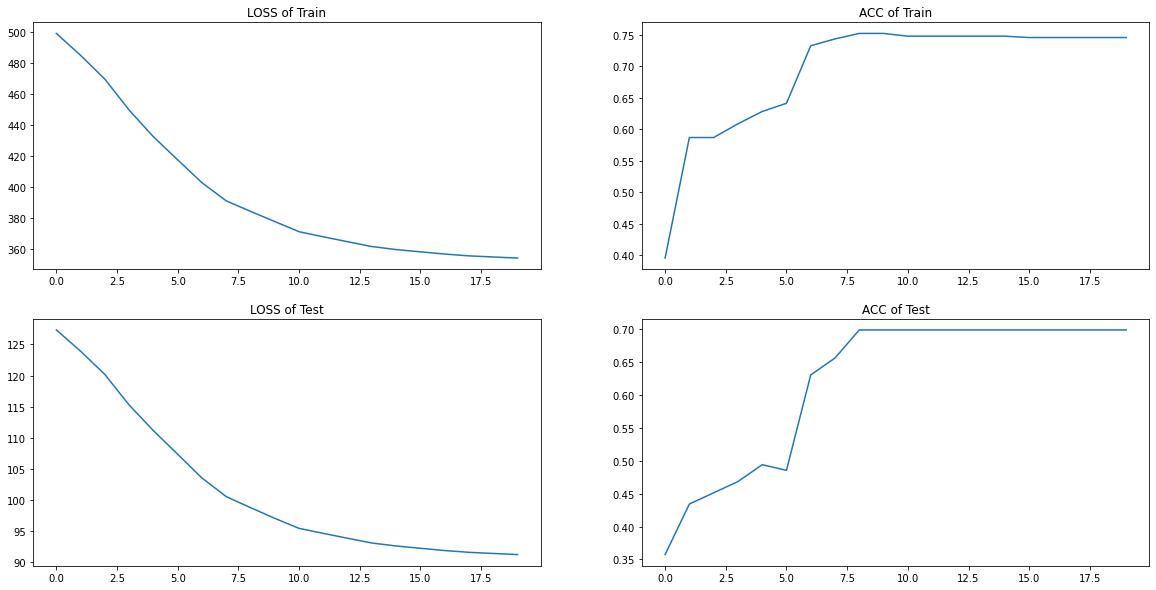

In [59]:
import  matplotlib.pyplot as plt  

fig,axs = plt.subplots(2,2,figsize=(20,10))

axs[0,0].plot(np.arange(len(loss_train)),loss_train)
axs[0,0].set_title('LOSS of Train')
axs[0,1].plot(np.arange(len(loss_train)),acc_train)
axs[0,1].set_title('ACC of Train')
axs[1,0].plot(np.arange(len(loss_train)),loss_val)
axs[1,0].set_title('LOSS of Test')
axs[1,1].plot(np.arange(len(loss_train)),acc_test)
axs[1,1].set_title('ACC of Test')



In [113]:
output_prediction =[]
labels = []
for x in range(3):
    train_x = torch.tensor(train_x_all[x])
    train_y = torch.tensor(train_y_all[x])
    test_x = torch.tensor(test_x_all[x])
    test_y = torch.tensor(test_y_all[x])
    outputs = model(train_x)
    output_prediction.append(np.array(torch.argmax(outputs,dim=1)))
    labels.append(np.array(torch.argmax(train_y,dim=1)))

In [108]:
output_prediction = np.array(output_prediction).reshape(-1,1)
labels = np.array(labels).reshape(-1,1)

In [119]:
pred = torch.tensor(np.hstack([np.hstack(i) for i in output_prediction]))
labels_ = torch.tensor(np.hstack([np.hstack(i) for i in labels]))

In [121]:
from torchmetrics import ConfusionMatrix

confmat = ConfusionMatrix(num_classes=3)
mat = confmat(pred, labels_)


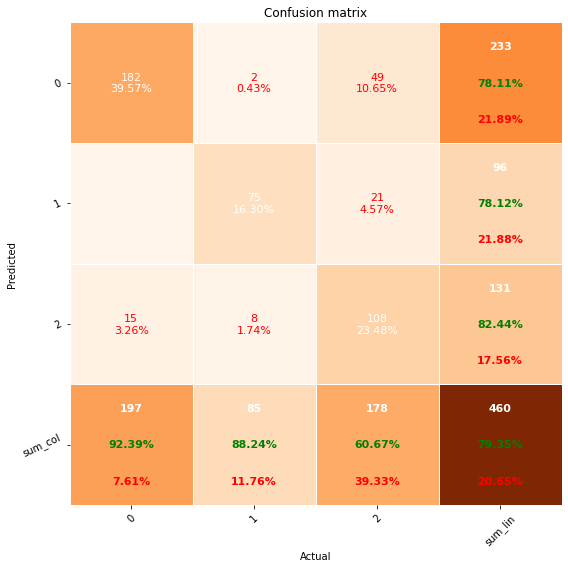

In [133]:
from pretty_confusion_matrix import pp_matrix

pp_matrix(pd.DataFrame(np.array(mat)))

